## Dataset Overview

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

In [4]:
df=pd.read_csv("/content/drive/MyDrive/MiniProject/overview-of-recordings.csv")

In [5]:
df_text = df[['phrase', 'prompt']]
df_text

,phrase,prompt
0,When I remember her I feel down,Emotional pain
1,When I carry heavy things I feel like breaking...,Hair falling out
2,there is too much pain when i move my arm,Heart hurts
3,My son had his lip pierced and it is swollen a...,Infected wound
4,My muscles in my lower back are aching,Infected wound
...,...,...
6656,I feel a burning sensation in my guts about 2 ...,Stomach ache
6657,I have a split on my thumb that will not heal.,Open wound
6658,I feel a lot of pain in the joints.,Joint pain
6659,The area around my heart doesn't feel good.,Heart hurts


In [6]:
df.columns

Index(['audio_clipping', 'audio_clipping:confidence',
       'background_noise_audible', 'background_noise_audible:confidence',
       'overall_quality_of_the_audio', 'quiet_speaker',
       'quiet_speaker:confidence', 'speaker_id', 'file_download', 'file_name',
       'phrase', 'prompt', 'writer_id'],
      dtype='object')

In [7]:
# Check the distribution of phrases and prompts
print("Unique phrases:", df['phrase'].nunique())
print("Unique prompts:", df['prompt'].nunique())
print("Unique speakers:", df['speaker_id'].nunique())

Unique phrases: 706
Unique prompts: 25
Unique speakers: 124


## Pandas profiling

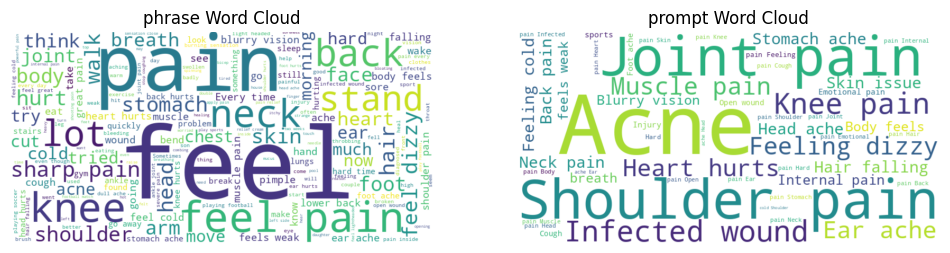

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all phrase and prompt into a single string
phrase_text = ' '.join(df['phrase'])
prompt_text = ' '.join(df['prompt'])

# Generate word clouds
phrase_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(phrase_text)
prompt_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(prompt_text)

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(phrase_wordcloud, interpolation='bilinear')
plt.title('phrase Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prompt_wordcloud, interpolation='bilinear')
plt.title('prompt Word Cloud')
plt.axis('off')

plt.show()


In [9]:
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [10]:
# from pandas_profiling import ProfileReport
# from ydata_profiling import ProfileReport
# profile=ProfileReport(df)
# profile.to_file("pandas_profile.html")

## NLP EDA (Apploying GloVe)

In [11]:
# download glove and unzip it in Notebook.
# Source GFG
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [12]:
# !pip install nltk

In [13]:
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from gensim.models import KeyedVectors

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Load stopwords
stopwords_set = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text, glove_model, stopwords_set):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords and out-of-vocabulary tokens
    tokens = [word for word in tokens if word not in stopwords_set and word in glove_model.key_to_index]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

>Loading GloVe

In [15]:
from gensim.models import KeyedVectors

# Path to the GloVe embeddings file
glove_file = 'glove.6B.100d.txt'  # Change this to the file you want to use

# Load the GloVe model
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [16]:
# Check if the word 'hello' is in the vocabulary
if 'hello' in glove_model.key_to_index:
    print("Word 'hello' is in the vocabulary.")
else:
    print("Word 'hello' is NOT in the vocabulary.")


Word 'hello' is in the vocabulary.


>Extracting cleaned data

In [17]:
# Apply preprocess_text function to 'phrase' column and create 'clean_phrase' column
df['clean_phrase'] = df['phrase'].apply(lambda x: preprocess_text(x, glove_model, stopwords_set))

# Apply preprocess_text function to 'prompt' column and create 'clean_prompt' column
df['clean_prompt'] = df['prompt'].apply(lambda x: preprocess_text(x, glove_model, stopwords_set))

In [18]:
df_clean = df[['clean_phrase', 'clean_prompt']]
df_clean

,clean_phrase,clean_prompt
0,remember feel,emotional pain
1,carry heavy things feel like breaking back,hair falling
2,much pain move arm,heart hurts
3,son lip pierced swollen skin inside lip grey l...,infected wound
4,muscles lower back aching,infected wound
...,...,...
6656,feel burning sensation guts 2 hours meal,stomach ache
6657,split thumb heal,open wound
6658,feel lot pain joints,joint pain
6659,area around heart doesnt feel good,heart hurts


## Final preprocessing before designing ANN

In [19]:
vocab = set()

# Tokenize and add words from 'clean_phrase' column
for text in df['clean_phrase']:
    tokens = text.split()
    vocab.update(tokens)

# Tokenize and add words from 'clean_prompt' column
for text in df['clean_prompt']:
    tokens = text.split()
    vocab.update(tokens)

vocab = list(vocab)  # Convert set to list to maintain consistent order


In [20]:
vocab_size = len(vocab)
embedding_dim = 100 # As using 100 dimension GloVe vectors

In [21]:
# Initialize an empty matrix for the embedding matrix
import numpy as np
glove_embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill the embedding matrix with GloVe vectors for words in the vocabulary
for i, word in enumerate(vocab):
    if word in glove_model.key_to_index:
        glove_embedding_matrix[i] = glove_model.get_vector(word)

## Designing ANN

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Instantiate a Tokenizer for clean_phrase
tokenizer_phrase = Tokenizer()
tokenizer_phrase.fit_on_texts(df['clean_phrase'])

# Instantiate a Tokenizer for clean_prompt
tokenizer_prompt = Tokenizer()
tokenizer_prompt.fit_on_texts(df['clean_prompt'])

# Convert 'clean_phrase' and 'clean_prompt' to sequences
sequences_phrase = tokenizer_phrase.texts_to_sequences(df['clean_phrase'])
sequences_prompt = tokenizer_prompt.texts_to_sequences(df['clean_prompt'])

In [25]:
# Find the maximum sequence length in clean_phrase and clean_prompt
max_seq_length_phrase = max(len(seq) for seq in sequences_phrase)
max_seq_length_prompt = max(len(seq) for seq in sequences_prompt)

# Choose the maximum between the two
max_seq_length = max(max_seq_length_phrase, max_seq_length_prompt)

print("Max sequence length:", max_seq_length)

Max sequence length: 14


In [26]:
# Split data into training and validation sets
X_train_phrase, X_val_phrase, y_train, y_val = train_test_split(sequences_phrase, df['clean_prompt'], test_size=0.2, random_state=42)

# Pad sequences to ensure uniform length
X_train_phrase = pad_sequences(X_train_phrase, maxlen=max_seq_length)
X_val_phrase = pad_sequences(X_val_phrase, maxlen=max_seq_length)

# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

## Evaluating model accuracy

>Simple ANN 10 epoch

In [27]:
from tensorflow.keras.optimizers import Adagrad

# Define your ANN model
model = Sequential()

# Add embedding layer
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[glove_embedding_matrix],
                    input_length=max_seq_length,
                    trainable=False))

# Flatten the embedding output
model.add(Flatten())

# Add hidden dense layer
model.add(Dense(256, activation='relu'))

# Add output layer
num_classes = len(df['clean_prompt'].unique())  # Number of unique prompts
model.add(Dense(num_classes, activation='softmax'))

# Compile model with Adagrad optimizer
optimizer = Adagrad(learning_rate=0.01)  # You can specify learning rate and other parameters here if needed
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [28]:
# Train model
history = model.fit(X_train_phrase, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val_phrase, y_val_encoded))

# Evaluate model
loss, accuracy = model.evaluate(X_val_phrase, y_val_encoded)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

Epoch 1/10
167/167 [==============================] - 3s 7ms/step - loss: 2.6536 - accuracy: 0.2971 - val_loss: 2.1665 - val_accuracy: 0.4209
Epoch 2/10
167/167 [==============================] - 1s 5ms/step - loss: 1.5825 - accuracy: 0.6751 - val_loss: 1.4305 - val_accuracy: 0.6564
Epoch 3/10
167/167 [==============================] - 1s 5ms/step - loss: 0.9746 - accuracy: 0.8480 - val_loss: 0.9003 - val_accuracy: 0.8305
Epoch 4/10
167/167 [==============================] - 1s 5ms/step - loss: 0.6435 - accuracy: 0.9195 - val_loss: 0.6751 - val_accuracy: 0.8912
Epoch 5/10
167/167 [==============================] - 1s 5ms/step - loss: 0.4544 - accuracy: 0.9548 - val_loss: 0.4666 - val_accuracy: 0.9422
Epoch 6/10
167/167 [==============================] - 1s 5ms/step - loss: 0.3350 - accuracy: 0.9743 - val_loss: 0.3557 - val_accuracy: 0.9692
Epoch 7/10
167/167 [==============================] - 1s 5ms/step - loss: 0.2604 - accuracy: 0.9829 - val_loss: 0.2785 - val_accuracy: 0.9842
Epoch 

> Early stopping 40 epoch

In [29]:
# Define your ANN model
model = Sequential()

# Add embedding layer
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[glove_embedding_matrix],
                    input_length=max_seq_length,
                    trainable=False))

# Flatten the embedding output
model.add(Flatten())

# Add hidden dense layer
model.add(Dense(256, activation='relu'))

# Add output layer
num_classes = len(df['clean_prompt'].unique())  # Number of unique prompts
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])


In [30]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history = model.fit(X_train_phrase, y_train_encoded, batch_size=32, epochs=40,
                    validation_data=(X_val_phrase, y_val_encoded), callbacks=[early_stopping])

# Evaluate model
loss, accuracy = model.evaluate(X_val_phrase, y_val_encoded)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

Epoch 1/40
167/167 [==============================] - 1s 5ms/step - loss: 1.8505 - accuracy: 0.5013 - val_loss: 0.9713 - val_accuracy: 0.7262
Epoch 2/40
167/167 [==============================] - 1s 4ms/step - loss: 0.4736 - accuracy: 0.8921 - val_loss: 0.2518 - val_accuracy: 0.9362
Epoch 3/40
167/167 [==============================] - 1s 3ms/step - loss: 0.1673 - accuracy: 0.9619 - val_loss: 0.3597 - val_accuracy: 0.8852
Epoch 4/40
167/167 [==============================] - 1s 4ms/step - loss: 0.0961 - accuracy: 0.9769 - val_loss: 0.0620 - val_accuracy: 0.9872
Epoch 5/40
167/167 [==============================] - 1s 3ms/step - loss: 0.0668 - accuracy: 0.9816 - val_loss: 0.3665 - val_accuracy: 0.9047
Epoch 6/40
167/167 [==============================] - 1s 3ms/step - loss: 0.0657 - accuracy: 0.9855 - val_loss: 0.4170 - val_accuracy: 0.8687
Epoch 7/40
167/167 [==============================] - 1s 4ms/step - loss: 0.0607 - accuracy: 0.9859 - val_loss: 0.0268 - val_accuracy: 0.9970
Epoch 